In [1]:
library(sf)
library(tmap)
library(tmaptools)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gstat)
library(sp)

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Breaking News: tmap 3.x is retiring. Please test v4, e.g. with
remotes::install_github('r-tmap/tmap')


载入程序包：‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



载入程序包：‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




Reading layer `nyct2020' from data source 
  `/Users/jiazhuangfeng/Documents/project/spatial_analysis/assignment/data/nyc2020_census/nyct2020.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2325 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 913175.1 ymin: 120128.4 xmax: 1067383 ymax: 272844.3
Projected CRS: NAD83 / New York Long Island (ftUS)


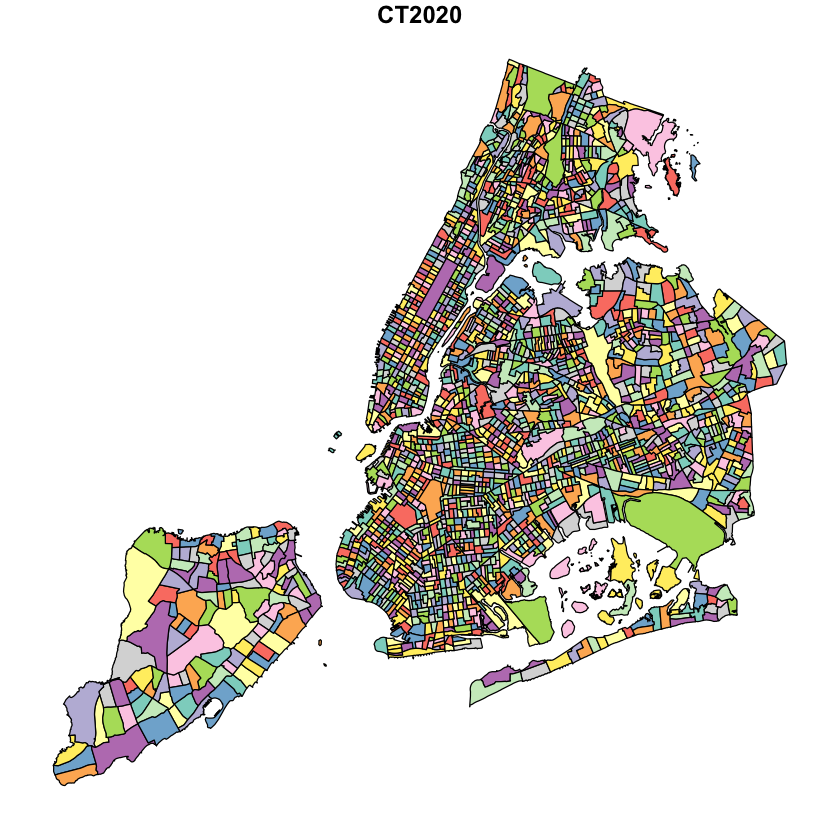

In [4]:
# Read the census shapefile
census <- st_read(dsn="./data/nyc2020_census/nyct2020.shp", layer="nyct2020")

# Load the population csv data
population <- read.csv("./data/nyc_censusdata_2020.csv")
population$BCT2020 <- as.character(population$BCT2020)

# Join population data to census data
census_joined <- census %>%
  left_join(population, by= c("BoroCT2020"="BCT2020"))

# Plot census polygons
plot(census_joined["CT2020"])

# Load Citibike data
citibike_oct_1 <- read.csv("./data/2020-citibike-tripdata/202010-citibike-tripdata_1.csv")
citibike_oct_2 <- read.csv("./data/2020-citibike-tripdata/202010-citibike-tripdata_2.csv")
citibike_oct_3 <- read.csv("./data/2020-citibike-tripdata/202010-citibike-tripdata_3.csv")

# Ensure consistent type for `start_station_id` and other columns
citibike_oct_1$start_station_id <- as.character(citibike_oct_1$start_station_id)
citibike_oct_2$start_station_id <- as.character(citibike_oct_2$start_station_id)
citibike_oct_3$start_station_id <- as.character(citibike_oct_3$start_station_id)

# Bind rows for October data
citibike_oct <- bind_rows(citibike_oct_1, citibike_oct_2, citibike_oct_3)

# Repeat for January data
citibike_jan_1 <- read.csv("./data/2020-citibike-tripdata/202001-citibike-tripdata_1.csv")
citibike_jan_2 <- read.csv("./data/2020-citibike-tripdata/202001-citibike-tripdata_2.csv")

# Ensure consistent type for `start_station_id` and other columns
citibike_jan_1$start_station_id <- as.character(citibike_jan_1$start_station_id)
citibike_jan_2$start_station_id <- as.character(citibike_jan_2$start_station_id)

# Bind rows for January data
citibike_jan <- bind_rows(citibike_jan_1, citibike_jan_2)


In [8]:
# 统计 1 月份的 ride_activity 数据
station_jan <- citibike_jan %>%
  group_by(start_station_id, start_lat, start_lng) %>%
  summarise(ride_start_count = n(), .groups = "drop") %>%
  rename(station_id = start_station_id, station_lat = start_lat, station_lng = start_lng)

end_station_jan <- citibike_jan %>%
  group_by(end_station_id, end_lat, end_lng) %>%
  summarise(ride_end_count = n(), .groups = "drop") %>%
  rename(station_id = end_station_id, station_lat = end_lat, station_lng = end_lng)

# 分别统计起点和终点的骑行次数，并计算总的 ride_activity
station_jan <- station_jan %>%
  full_join(end_station_jan, by = c("station_id", "station_lat", "station_lng")) %>%
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  ) %>%
  select(station_id, station_lat, station_lng, ride_activity) # 仅保留所需列

# 统计 10 月份的 ride_activity 数据
station_oct <- citibike_oct %>%
  group_by(start_station_id, start_lat, start_lng) %>%
  summarise(ride_start_count = n(), .groups = "drop") %>%
  rename(station_id = start_station_id, station_lat = start_lat, station_lng = start_lng)

end_station_oct <- citibike_oct %>%
  group_by(end_station_id, end_lat, end_lng) %>%
  summarise(ride_end_count = n(), .groups = "drop") %>%
  rename(station_id = end_station_id, station_lat = end_lat, station_lng = end_lng)

# 分别统计起点和终点的骑行次数，并计算总的 ride_activity
station_oct <- station_oct %>%
  full_join(end_station_oct, by = c("station_id", "station_lat", "station_lng")) %>%
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  ) %>%
  select(station_id, station_lat, station_lng, ride_activity) # 仅保留所需列


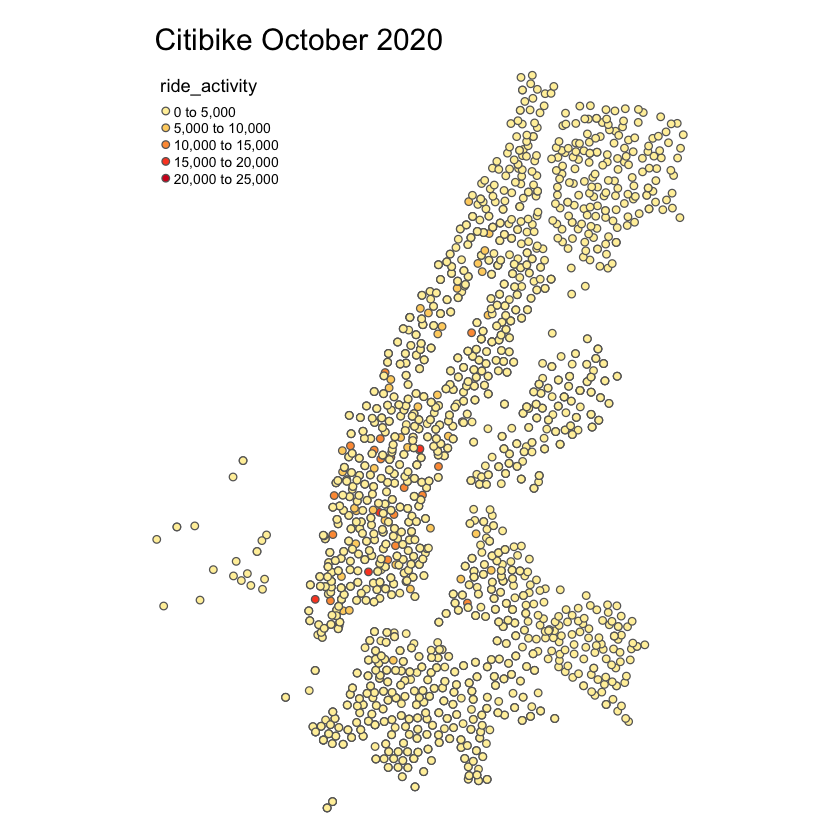

In [11]:
# 移除 station_lng 或 station_lat 中存在 NA 的行
station_oct_clean <- station_oct %>%
  filter(!is.na(station_lng) & !is.na(station_lat))

# 转换为 sf 对象
station_oct_sf <- station_oct_clean %>%
  st_as_sf(coords = c("station_lng", "station_lat"), crs = 4326, remove = FALSE)

# 绘制地图
tm_shape(station_oct_sf) +
  tm_bubbles(size = 0.1, col = "ride_activity", palette = "YlOrRd") +
  tm_layout(
    main.title = "Citibike October 2020",
    main.title.size = 1.5,
    frame = FALSE,
    legend.position = c("left", "top")
  )


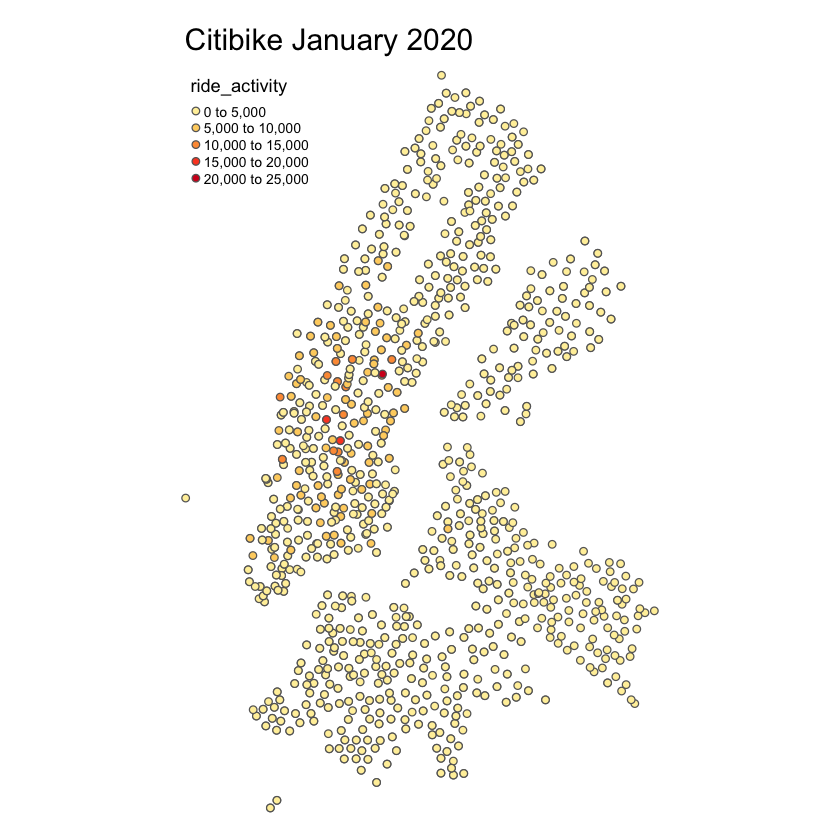

In [12]:
# 移除 station_lng 或 station_lat 中存在 NA 的行（针对 1 月数据）
station_jan_clean <- station_jan %>%
  filter(!is.na(station_lng) & !is.na(station_lat))

# 转换为 sf 对象
station_jan_sf <- station_jan_clean %>%
  st_as_sf(coords = c("station_lng", "station_lat"), crs = 4326, remove = FALSE)

# 绘制地图
tm_shape(station_jan_sf) +
  tm_bubbles(size = 0.1, col = "ride_activity", palette = "YlOrRd") +
  tm_layout(
    main.title = "Citibike January 2020",
    main.title.size = 1.5,
    frame = FALSE,
    legend.position = c("left", "top")
  )


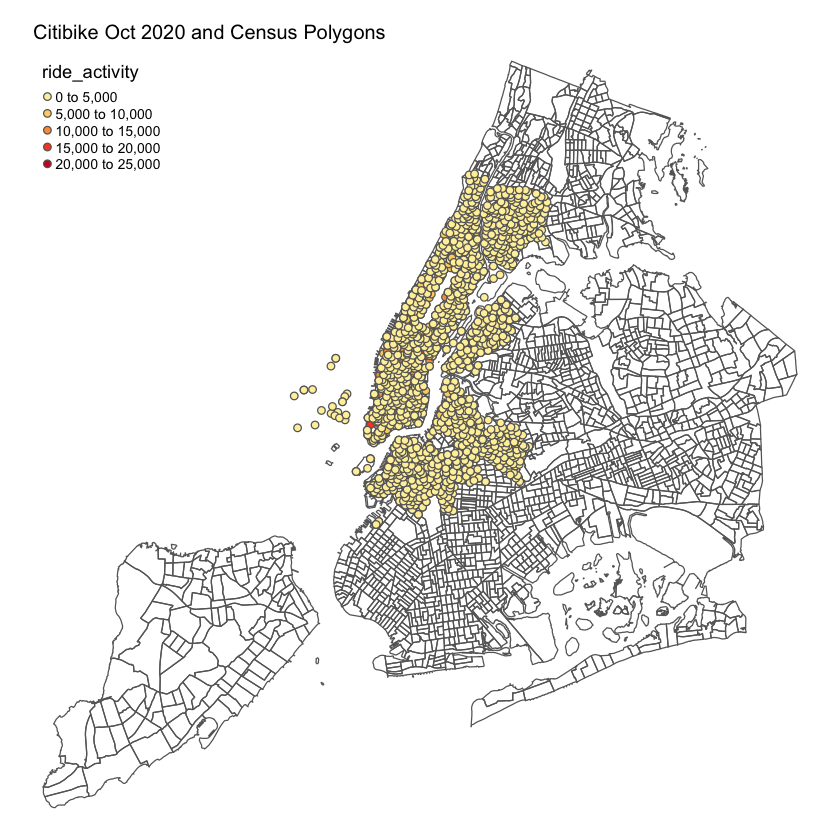

In [14]:
# 转换 Census 数据的 CRS 为与 station_oct_sf 一致
census_joined <- st_transform(census_joined, crs = st_crs(station_oct_sf))

# 绘制地图
tm_shape(census) +
  tm_borders() +
  tm_shape(station_oct_sf) +  # 使用 station_oct_sf 而不是 station_oct_clean
  tm_bubbles(size = 0.1, col = "ride_activity", palette = "YlOrRd") + 
  tm_layout(
    main.title = "Citibike Oct 2020 and Census Polygons",
    main.title.size = 1,
    frame = FALSE,
    legend.position = c("left", "top")
  )


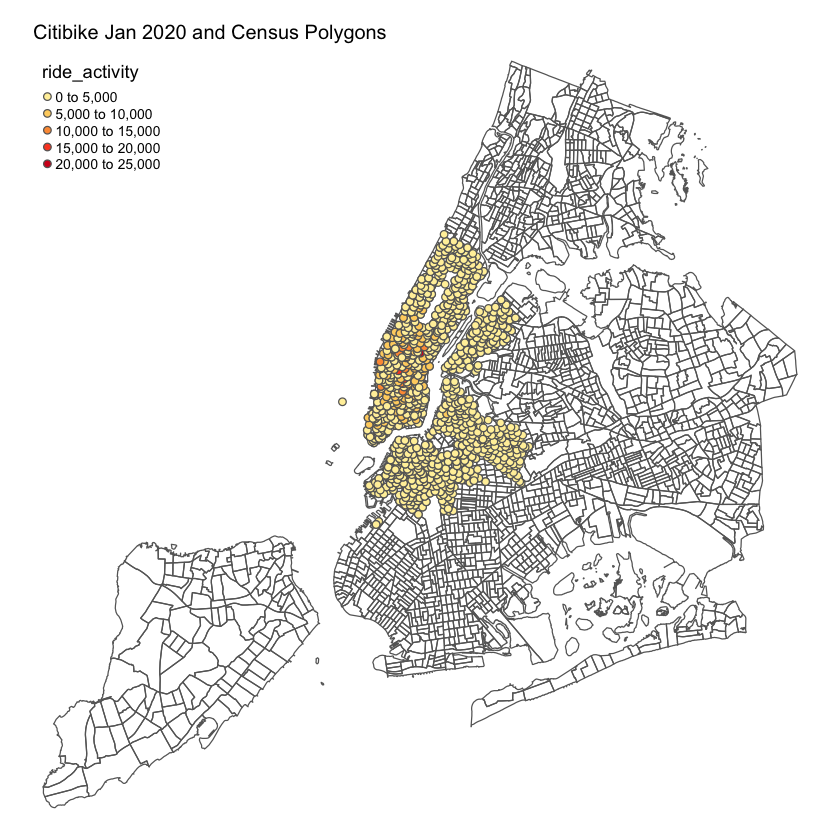

In [15]:
# 转换 Census 数据的 CRS 为与 station_jan_sf 一致
census_joined <- st_transform(census_joined, crs = st_crs(station_jan_sf))

# 绘制地图
tm_shape(census) +
  tm_borders() +
  tm_shape(station_jan_sf) +  # 使用 station_jan_sf
  tm_bubbles(size = 0.1, col = "ride_activity", palette = "YlOrRd") + 
  tm_layout(
    main.title = "Citibike Jan 2020 and Census Polygons",
    main.title.size = 1,
    frame = FALSE,
    legend.position = c("left", "top")
  )


In [17]:
# 1. 将站点数据与 Census 数据通过地理位置关联
station_oct_nyc <- station_oct_sf %>%
  st_join(census_joined, join = st_within, left = FALSE)

# 2. 按 Census Tract 聚合站点数据
ct_station_oct <- station_oct_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    num_stations = n(),  # 站点数量
    total_ride_activity = sum(ride_activity, na.rm = TRUE)  # 总骑行活动
  )

# 3. 转换为 DataFrame 并与 Census 数据合并
ct_station_oct_df <- as.data.frame(ct_station_oct)
agg_citibike_oct <- census_joined %>%
  inner_join(ct_station_oct_df, by = "BoroCT2020")

# 4. 转换人口相关列为数值
columns_to_convert <- c("Pop1", "PopU5", "Pop5t9", "Pop10t14", "Pop15t19", "Pop20t24", 
                        "Pop25t29", "Pop30t34", "Pop35t39", "PopU18", "Pop65pl", 
                        "GQClgHsg", "Fam", "HUnits")
agg_citibike_oct[columns_to_convert] <- lapply(agg_citibike_oct[columns_to_convert], function(x) {
  x <- gsub(",", "", x)             # 移除逗号
  x <- as.numeric(x)                # 转换为数值
  x[is.na(x)] <- 0                  # 替换 NA 为 0
  return(x)
})


Warning message in FUN(X[[i]], ...):
“强制改变过程中产生了NA”
Warning message in `[<-.data.frame`(`*tmp*`, columns_to_convert, value = list(Pop1 = c(11616, :
“提供了15变量用来替换14变量”


In [18]:
# 1. 将站点数据与 Census 数据通过地理位置关联
station_jan_nyc <- station_jan_sf %>%
  st_join(census_joined, join = st_within, left = FALSE)

# 2. 按 Census Tract 聚合站点数据
ct_station_jan <- station_jan_nyc %>%
  group_by(BoroCT2020) %>%
  summarise(
    num_stations = n(),  # 站点数量
    total_ride_activity = sum(ride_activity, na.rm = TRUE)  # 总骑行活动
  )

# 3. 转换为 DataFrame 并与 Census 数据合并
ct_station_jan_df <- as.data.frame(ct_station_jan)
agg_citibike_jan <- census_joined %>%
  inner_join(ct_station_jan_df, by = "BoroCT2020")

# 4. 转换人口相关列为数值
agg_citibike_jan[columns_to_convert] <- lapply(agg_citibike_jan[columns_to_convert], function(x) {
  x <- gsub(",", "", x)             # 移除逗号
  x <- as.numeric(x)                # 转换为数值
  x[is.na(x)] <- 0                  # 替换 NA 为 0
  return(x)
})


Warning message in FUN(X[[i]], ...):
“强制改变过程中产生了NA”
Warning message in `[<-.data.frame`(`*tmp*`, columns_to_convert, value = list(Pop1 = c(11616, :
“提供了15变量用来替换14变量”


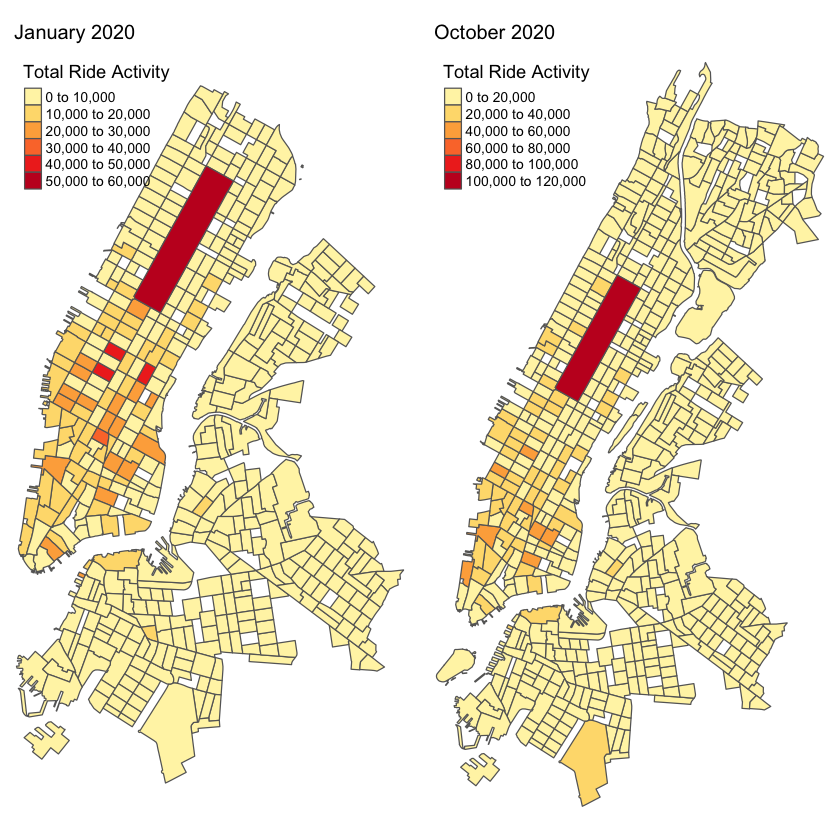

In [19]:
# 1. 创建 10 月地图
map_oct <- tm_shape(agg_citibike_oct) +
  tm_borders() +
  tm_fill(
    col = "total_ride_activity",
    palette = "YlOrRd",
    title = "Total Ride Activity"
  ) +
  tm_layout(
    main.title = "October 2020",
    main.title.size = 1,
    frame = FALSE,
    legend.position = c("left", "top")
  )

# 2. 创建 1 月地图
map_jan <- tm_shape(agg_citibike_jan) +
  tm_borders() +
  tm_fill(
    col = "total_ride_activity",
    palette = "YlOrRd",
    title = "Total Ride Activity"
  ) +
  tm_layout(
    main.title = "January 2020",
    main.title.size = 1,
    frame = FALSE,
    legend.position = c("left", "top")
  )

# 3. 并排显示两个地图
tmap_arrange(map_jan, map_oct, ncol = 2)


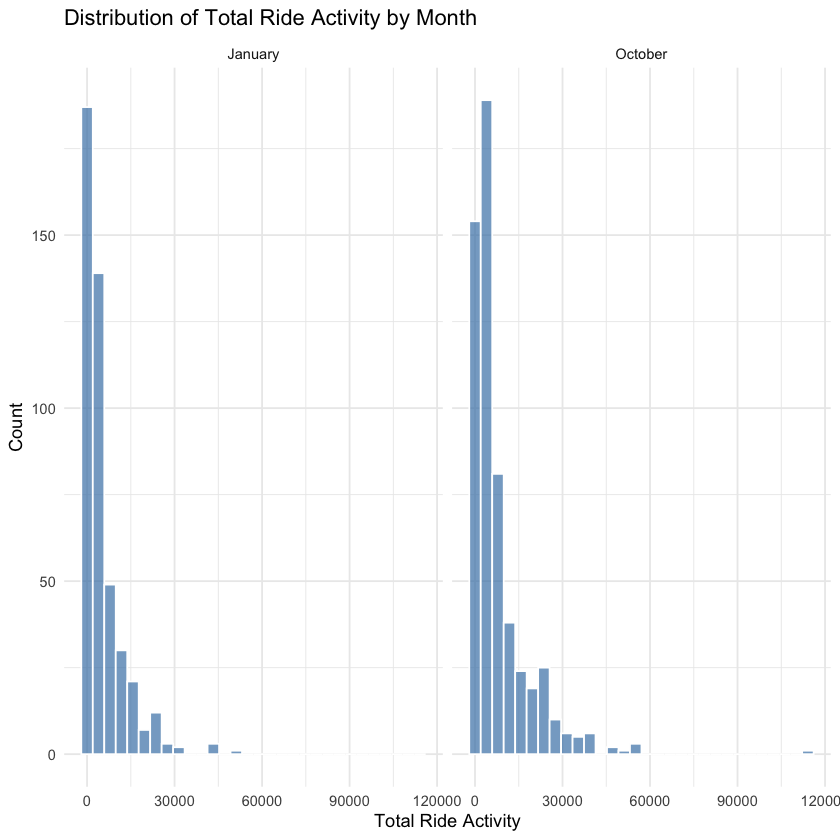

In [21]:
# 添加月份列并合并数据
agg_citibike_oct$month <- "October"
agg_citibike_jan$month <- "January"

# 合并数据
agg_citibike_combined <- rbind(
  agg_citibike_oct[, c("total_ride_activity", "month")],
  agg_citibike_jan[, c("total_ride_activity", "month")]
)
library(ggplot2)

ggplot(data = agg_citibike_combined, aes(x = total_ride_activity)) +
  geom_histogram(bins = 30, fill = "steelblue", color = "white", alpha = 0.7) +
  labs(
    title = "Distribution of Total Ride Activity by Month",
    x = "Total Ride Activity",
    y = "Count"
  ) +
  facet_wrap(~month, ncol = 2) +  # 分面显示
  theme_minimal()



In [23]:
# 提取 CT2020 列为向量
ct2020_jan_vector <- agg_citibike_jan$CT2020
ct2020_oct_vector <- agg_citibike_oct$CT2020
# 找出 1 月有而 10 月没有的值
jan_not_in_oct <- setdiff(ct2020_jan_vector, ct2020_oct_vector)

# 找出 10 月有而 1 月没有的值
oct_not_in_jan <- setdiff(ct2020_oct_vector, ct2020_jan_vector)
# 打印结果并计数
cat("1 月有而 10 月没有的值 (共", length(jan_not_in_oct), "个)：", jan_not_in_oct, "\n")
cat("10 月有而 1 月没有的值 (共", length(oct_not_in_jan), "个)：", oct_not_in_jan, "\n")


1 月有而 10 月没有的值 (共 3 个)： 007800 009901 031900 
10 月有而 1 月没有的值 (共 46 个)： 021703 022102 022301 022600 022800 023100 024301 002701 002702 006302 017901 018102 018302 020900 021302 022300 022500 012701 000500 023501 022302 021000 021200 014702 018500 025900 023000 023200 023700 021400 014701 014100 023900 023803 023804 011502 012300 009301 017702 024700 018502 024302 031100 023600 006301 024000 


In [24]:
# 打印 1 月和 10 月的 CT2020 总数量
cat("1 月的 CT2020 总数量：", length(ct2020_jan_vector), "\n")
cat("10 月的 CT2020 总数量：", length(ct2020_oct_vector), "\n")

1 月的 CT2020 总数量： 454 
10 月的 CT2020 总数量： 564 


In [25]:
ct2020_2019_oct <- read.csv("CT2020_2019_10.csv", colClasses = c("CT2020" = "character"))
ct2020_2019_oct_vector <- ct2020_2019_oct$CT2020

In [26]:
cat("2019年10月的 CT2020 总数量：", length(ct2020_2019_oct_vector), "\n")

2019年10月的 CT2020 总数量： 435 


In [27]:
# 找出 1 月有而 10 月没有的值
jan_not_in_oct <- setdiff(ct2020_jan_vector, ct2020_2019_oct_vector)

# 找出 10 月有而 1 月没有的值
oct_not_in_jan <- setdiff(ct2020_2019_oct_vector , ct2020_jan_vector)
# 打印结果并计数
cat("2020年 1 月有而 2019年10 月没有的值 (共", length(jan_not_in_oct), "个)：", jan_not_in_oct, "\n")
cat("2019年 10 月有而 2020年1 月没有的值 (共", length(oct_not_in_jan), "个)：", oct_not_in_jan, "\n")

2020年 1 月有而 2019年10 月没有的值 (共 11 个)： 016500 053901 053902 054500 055900 058900 000101 036900 040500 031900 036700 
2019年 10 月有而 2020年1 月没有的值 (共 1 个)： 000500 
